This notebook will implement machine learning to accelerate the discovery of high-entropy energy storage ceramic thin films.

# Import package

In [1]:
import os
import re
import time
import random
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.utils.data as Data
from torch.optim import Adam, lr_scheduler
from torch.utils.data import Dataset, DataLoader
from scipy.spatial.distance import cdist
from sklearn.model_selection import train_test_split, KFold
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.patches import Ellipse
from mpl_toolkits.axes_grid1 import make_axes_locatable
import seaborn as sns
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF
from scipy.stats import linregress
from bayes_opt import BayesianOptimization
from sklearn.metrics import mean_squared_error
from lightgbm import LGBMRegressor
from sklearn.decomposition import PCA
from matplotlib.pyplot import MultipleLocator
from sklearn import preprocessing

# Check if CUDA is available, otherwise use CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Set seaborn for better visualizations
sns.set(color_codes=True)

## Some functions
* "same_seeds" function ensures that the random seeds for NumPy and PyTorch are fixed.

* "FeatureDataset" class is a custom dataset class used to convert numpy arrays to PyTorch tensors.

* "WAE" class defines an Autoencoder model.

* "get_latents" function extracts latent representations from a trained model.

* "imq_kernel" function computes  the Inverse Multi-Quadratic (IMQ) kernel between two sets of samples to loss function.








In [2]:
import torch
import torch.nn as nn
import numpy as np
from torch.utils.data import Dataset, DataLoader
import random

def same_seeds(seed):
    '''
    Fix random seeds for NumPy and PyTorch for reproducibility.

    Args:
        seed: Random seed value.
    '''
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)  # if you are using multi-GPU.
    np.random.seed(seed)  # NumPy module.
    random.seed(seed)  # Python random module.
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

class FeatureDataset(Dataset):
    '''
    Dataset for converting numpy arrays to tensors.

    Args:
        x: A 2D numpy array [x_size, x_features] containing input features.
        y: A 2D numpy array [y_size, y_features] containing target labels.
    '''

    def __init__(self, x, y):
        '''
        Initialize the dataset with input features and target labels.

        Args:
            x: Input features as a 2D numpy array.
            y: Target labels as a 2D numpy array.
        '''
        self.x = torch.FloatTensor(x)  # Convert numpy array to PyTorch tensor
        self.y = torch.FloatTensor(y)  # Convert numpy array to PyTorch tensor

    def __len__(self):
        '''
        Returns the length of the dataset.

        Returns:
            Length of the dataset (number of samples).
        '''
        return len(self.x)

    def __getitem__(self, idx):
        '''
        Get a sample from the dataset by index.

        Args:
            idx: Index of the sample to retrieve.

        Returns:
            Tuple containing the input features and target label for the sample.
        '''
        return self.x[idx], self.y[idx]

class WAE(nn.Module):
    def __init__(self, input_size):
        '''
        Wasserstein Autoencoder (WAE) model architecture.

        Args:
            input_size: The size of input features.
        '''
        super(WAE, self).__init__()
        self.input_size = input_size

        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(self.input_size, 80),
            nn.LayerNorm(80),
            nn.ReLU(),
            nn.Linear(80, 64),
            nn.LayerNorm(64),
            nn.ReLU(),
            nn.Linear(64, 48),
            nn.LayerNorm(48),
            nn.ReLU(),
            nn.Linear(48, 2),
        )

        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(2, 48),
            nn.LayerNorm(48),
            nn.ReLU(),
            nn.Linear(48, 64),
            nn.LayerNorm(64),
            nn.ReLU(),
            nn.Linear(64, 80),
            nn.LayerNorm(80),
            nn.ReLU(),
            nn.Linear(80, self.input_size),
            nn.Softmax(dim=1),  # Apply softmax along dimension 1
        )

        # Initialize weights
        self.apply(weights_init)

    def forward(self, x):
        '''
        Forward pass of the WAE model.

        Args:
            x: Input tensor.

        Returns:
            x_recon: Reconstructed input tensor.
            z: Encoded latent representation.
        '''
        z = self.encoder(x)
        x_recon = self.decoder(z)
        return x_recon, z
    
    def _decode(self, z):
        return self.decoder(z)
    
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)

def get_latents(model, dataset):
    '''
    Extract latent representations from a trained model for a given dataset.

    Args:
        model: Trained PyTorch model.
        dataset: Dataset containing input features.

    Returns:
        Concatenated latent representations as a NumPy array.
    '''
    model.eval()  # Set model to evaluation mode
    latents = []
    with torch.no_grad():  # Disable gradient computation
        dataloader = DataLoader(dataset, batch_size=256, shuffle=False)
        for x, _ in dataloader:
            z = model.encoder(x.to(device))
            latents.append(z.cpu().numpy())
    return np.concatenate(latents, axis=0)

def imq_kernel(X: torch.Tensor, Y: torch.Tensor, h_dim: int): # common kerntl to choose
    batch_size = X.size(0)

    norms_x = X.pow(2).sum(1, keepdim=True)  # batch_size x 1
    prods_x = torch.mm(X, X.t()).to(device)  # batch_size x batch_size
    dists_x = norms_x + norms_x.t() - 2 * prods_x # mm matrix multiplicaiton

    norms_y = Y.pow(2).sum(1, keepdim=True).to(device)  # batch_size x 1
    prods_y = torch.mm(Y, Y.t()).to(device)  # batch_size x batch_size
    dists_y = norms_y + norms_y.t() - 2 * prods_y

    dot_prd = torch.mm(X, Y.t())
    dists_c = norms_x + norms_y.t() - 2 * dot_prd

    stats = 0
    for scale in [.1, .2, .5, 1., 2., 5., 10.]: # need more study on this
        C = 2 * h_dim * 1.0 * scale
        res1 = C / (C + dists_x)
        res1 += C / (C + dists_y)

        if torch.cuda.is_available():
            res1 = (1 - torch.eye(batch_size).to(device)) * res1
        else:
            res1 = (1 - torch.eye(batch_size)) * res1

        res1 = res1.sum() / (batch_size - 1)
        res2 = C / (C + dists_c)
        res2 = res2.sum() * 2. / (batch_size)
        stats += res1 - res2

    return stats


## Data load

In [3]:
# Set random seeds for reproducibility
same_seeds(1)

# Parameters for WAE training
params = {
    'num_epoch': 300,
    'batch_size': 10,
    'lr': 1e-3,
    'weight_decay': 0.0,
    'sigma': 3.0,
    'MMD_lambda': 1e-3,
    'model_name': 'WAE',
}

# Load data
all_data = pd.read_csv('origin_data.csv', header=0).iloc[:, 2:].to_numpy()
raw_x = all_data[:, 0:9]
raw_x_A = all_data[:, 0:4]
raw_x_B = all_data[:, 4:9]
raw_y = all_data[:, -2].reshape(-1, 1)

# Convert numpy arrays to tensors
dataset = FeatureDataset(raw_x, raw_y)
dataloader = DataLoader(dataset, batch_size=params['batch_size'], shuffle=True)

# Print first 5 input and target samples for checking
print(raw_x[:5], raw_y[:5])

[[0.9  0.1  0.   0.   0.45 0.45 0.05 0.05 0.  ]
 [0.9  0.1  0.   0.   0.45 0.45 0.05 0.05 0.  ]
 [0.9  0.1  0.   0.   0.45 0.45 0.05 0.05 0.  ]
 [0.9  0.1  0.   0.   0.45 0.45 0.05 0.05 0.  ]
 [0.9  0.1  0.   0.   0.45 0.45 0.05 0.05 0.  ]] [[ 7.14]
 [25.32]
 [53.83]
 [48.83]
 [55.29]]


## Reconstruction of A&B site compositon

E:\work\high-entropy ceramic\WAE
[001/300] loss: 0.893734 Recon_loss: 0.885818, MMD_loss:7.915584
[002/300] loss: 0.619560 Recon_loss: 0.611244, MMD_loss:8.315926
[003/300] loss: 0.592592 Recon_loss: 0.585416, MMD_loss:7.176550
[004/300] loss: 0.589481 Recon_loss: 0.581358, MMD_loss:8.122170
[005/300] loss: 0.585309 Recon_loss: 0.577592, MMD_loss:7.717197
[006/300] loss: 0.581700 Recon_loss: 0.574052, MMD_loss:7.647805
[007/300] loss: 0.576626 Recon_loss: 0.570063, MMD_loss:6.562579
[008/300] loss: 0.573063 Recon_loss: 0.565886, MMD_loss:7.176476
[009/300] loss: 0.571818 Recon_loss: 0.565009, MMD_loss:6.809786
[010/300] loss: 0.567480 Recon_loss: 0.560738, MMD_loss:6.742326
[011/300] loss: 0.569391 Recon_loss: 0.562781, MMD_loss:6.610810
[012/300] loss: 0.565793 Recon_loss: 0.560203, MMD_loss:5.590330
[013/300] loss: 0.565347 Recon_loss: 0.559291, MMD_loss:6.055845
[014/300] loss: 0.565353 Recon_loss: 0.559322, MMD_loss:6.031364
[015/300] loss: 0.565117 Recon_loss: 0.559113, MMD_loss:6

[129/300] loss: 0.537822 Recon_loss: 0.536359, MMD_loss:1.462272
[130/300] loss: 0.538968 Recon_loss: 0.537671, MMD_loss:1.296975
[131/300] loss: 0.537877 Recon_loss: 0.536536, MMD_loss:1.340932
[132/300] loss: 0.538575 Recon_loss: 0.537209, MMD_loss:1.366366
[133/300] loss: 0.538346 Recon_loss: 0.536761, MMD_loss:1.584924
[134/300] loss: 0.537573 Recon_loss: 0.536115, MMD_loss:1.457458
[135/300] loss: 0.536822 Recon_loss: 0.535341, MMD_loss:1.481513
[136/300] loss: 0.540431 Recon_loss: 0.539054, MMD_loss:1.377141
[137/300] loss: 0.539218 Recon_loss: 0.537993, MMD_loss:1.225434
[138/300] loss: 0.537987 Recon_loss: 0.536461, MMD_loss:1.525716
[139/300] loss: 0.536651 Recon_loss: 0.535257, MMD_loss:1.393804
[140/300] loss: 0.538554 Recon_loss: 0.537268, MMD_loss:1.286115
[141/300] loss: 0.537341 Recon_loss: 0.536236, MMD_loss:1.105264
[142/300] loss: 0.539486 Recon_loss: 0.538321, MMD_loss:1.165002
[143/300] loss: 0.540763 Recon_loss: 0.539289, MMD_loss:1.473857
[144/300] loss: 0.539374 

[259/300] loss: 0.536988 Recon_loss: 0.535729, MMD_loss:1.258783
[260/300] loss: 0.538205 Recon_loss: 0.537277, MMD_loss:0.927844
[261/300] loss: 0.540761 Recon_loss: 0.539189, MMD_loss:1.572616
[262/300] loss: 0.538959 Recon_loss: 0.537684, MMD_loss:1.274784
[263/300] loss: 0.538820 Recon_loss: 0.537526, MMD_loss:1.293639
[264/300] loss: 0.535937 Recon_loss: 0.534485, MMD_loss:1.451619
[265/300] loss: 0.536807 Recon_loss: 0.535781, MMD_loss:1.025399
[266/300] loss: 0.538050 Recon_loss: 0.537225, MMD_loss:0.824671
[267/300] loss: 0.535043 Recon_loss: 0.533987, MMD_loss:1.056003
[268/300] loss: 0.536409 Recon_loss: 0.535249, MMD_loss:1.159790
[269/300] loss: 0.536027 Recon_loss: 0.535024, MMD_loss:1.002509
[270/300] loss: 0.539546 Recon_loss: 0.538189, MMD_loss:1.357523
[271/300] loss: 0.538975 Recon_loss: 0.537696, MMD_loss:1.278508
[272/300] loss: 0.540176 Recon_loss: 0.538580, MMD_loss:1.595464
[273/300] loss: 0.536052 Recon_loss: 0.534758, MMD_loss:1.293632
[274/300] loss: 0.538233 

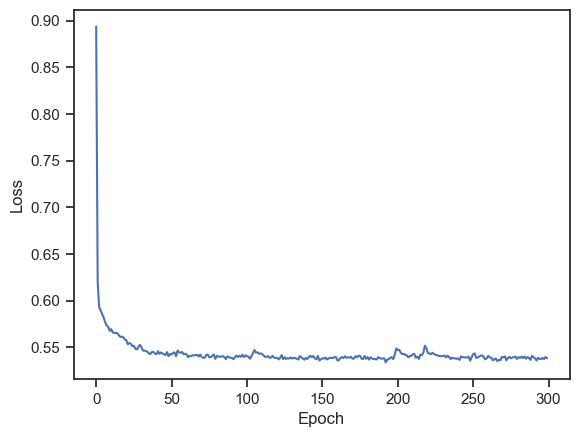

In [4]:
# Initialize models and optimizers for encoding A and B site separately
model_A = WAE(raw_x_A.shape[1]).to(device)
optimizer_A = Adam(model_A.parameters(), lr=params['lr'], weight_decay=params['weight_decay'])

model_B = WAE(raw_x_B.shape[1]).to(device)
optimizer_B = Adam(model_B.parameters(), lr=params['lr'], weight_decay=params['weight_decay'])

def train_WAE(model_A, model_B, optimizer_A, optimizer_B, dataloader, params):
    '''
    Train Wasserstein Autoencoder (WAE) models for encoding A and B separately.

    Args:
        model_A: WAE model for encoding A.
        model_B: WAE model for encoding B.
        optimizer_A: Optimizer for model_A.
        optimizer_B: Optimizer for model_B.
        dataloader: DataLoader for the dataset.
        params: Dictionary containing training parameters.

    Returns:
        loss_: List containing the training loss for each epoch.
    '''
    model_name = params['model_name']
    num_epoch = params['num_epoch']
    sigma = params['sigma']
    MMD_lambda = params['MMD_lambda']
    folder_dir = os.path.join(os.getcwd(), model_name)
    print(folder_dir)

    if not os.path.isdir(folder_dir):
        os.mkdir(folder_dir)

    loss_ = []

    for epoch in range(num_epoch):
        total_loss = []
        total_recon = []
        total_MMD = []

        for i, data in enumerate(dataloader):
            x = data[0].to(device)
            x_A = data[0].to(device)[:, :4]
            x_B = data[0].to(device)[:, 4:]
            y = data[1].to(device)

            model_A.train()
            model_B.train()

            recon_x_A, z_tilde_A = model_A(x_A)
            recon_x_B, z_tilde_B = model_B(x_B)

            z_A = sigma * torch.randn(z_tilde_A.size()).to(device)
            z_B = sigma * torch.randn(z_tilde_B.size()).to(device)

            recon_loss = F.binary_cross_entropy(recon_x_A, x_A, reduction='mean') + \
                         F.binary_cross_entropy(recon_x_B, x_B, reduction='mean')

            MMD_loss = imq_kernel(z_tilde_A, z_A, h_dim=2).to(device) + \
                       imq_kernel(z_tilde_B, z_B, h_dim=2).to(device)
            MMD_loss = MMD_loss / x_A.size(0)

            loss = recon_loss + MMD_loss * MMD_lambda

            optimizer_A.zero_grad()
            optimizer_B.zero_grad()
            loss.backward()
            optimizer_A.step()
            optimizer_B.step()

            total_loss.append(loss.item())
            total_recon.append(recon_loss.item())
            total_MMD.append(MMD_loss.item())

        avg_loss = sum(total_loss) / len(total_loss)
        avg_recon = sum(total_recon) / len(total_recon)
        avg_MMD = sum(total_MMD) / len(total_MMD)

        loss_.append(avg_loss)

        print('[{:03}/{:03}] loss: {:.6f} Recon_loss: {:.6f}, MMD_loss:{:.6f}'.format(\
            epoch+1, num_epoch, avg_loss, avg_recon, avg_MMD))

        if (epoch+1) % 5 == 0:
            save_model_dir_A = str(model_name + "_A{}.pth".format(epoch+1))
            save_model_dir_B = str(model_name + "_B{}.pth".format(epoch+1))
            torch.save(model_A.state_dict(), os.path.join(folder_dir, save_model_dir_A))
            torch.save(model_B.state_dict(), os.path.join(folder_dir, save_model_dir_B))

    return loss_

loss_ = train_WAE(model_A, model_B, optimizer_A, optimizer_B, dataloader, params)

plt.figure()
sns.set_style('ticks')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.plot(range(len(loss_)), loss_)


### **Double check on the reconstructed compositions**

*   one way to find out whether WAE (or any other VAE) has learned the 
repsentation is to compare the reconstructed and original compositions.if you are not happy with the reconstruction. go back to the previous step and change the params. 

In [5]:
# Set model names and folder directories
model_name = params['model_name']
folder_dir = os.path.join(os.getcwd(), model_name)

# Load trained models
model_dir_A = os.path.join(folder_dir, '{}_A{}.pth'.format(params['model_name'], params['num_epoch']))
model_dir_B = os.path.join(folder_dir, '{}_B{}.pth'.format(params['model_name'], params['num_epoch']))

model_A = WAE(raw_x_A.shape[1]).to(device)
model_B = WAE(raw_x_B.shape[1]).to(device)

model_A.load_state_dict(torch.load(model_dir_A))
model_B.load_state_dict(torch.load(model_dir_B))

model_A.eval()
model_B.eval()

# Reconstruct compositions
with torch.no_grad():
    test_A = torch.FloatTensor(raw_x_A).to(device)
    test_B = torch.FloatTensor(raw_x_B).to(device)

    recon_x_A, z_A = model_A(test_A)
    recon_x_A = model_A.decoder(z_A)
    recon_x_A = recon_x_A.cpu().detach().numpy()

    recon_x_B, z_B = model_B(test_B)
    recon_x_B = model_B.decoder(z_B)
    recon_x_B = recon_x_B.cpu().detach().numpy()

    recon_x = np.concatenate((recon_x_A, recon_x_B), axis=1)

# Define column names
column_names = ['Bi', 'La', 'Sr', 'Ca', 'Ti', 'Mg', 'Mn', 'Zr', 'Hf']

# Display reconstructed compositions
pd.DataFrame(recon_x.round(4), columns=column_names).iloc[:5]  # Print the first 77 reconstructed samples


,Bi,La,Sr,Ca,Ti,Mg,Mn,Zr,Hf
0,0.898,0.102,0.0,0.0,0.4532,0.4472,0.0458,0.0538,0.0
1,0.898,0.102,0.0,0.0,0.4532,0.4472,0.0458,0.0538,0.0
2,0.898,0.102,0.0,0.0,0.4532,0.4472,0.0458,0.0538,0.0
3,0.898,0.102,0.0,0.0,0.4532,0.4472,0.0458,0.0538,0.0
4,0.898,0.102,0.0,0.0,0.4532,0.4472,0.0458,0.0538,0.0


In [6]:
pd.DataFrame(raw_x[:5,:9].round(4), columns=column_names)

,Bi,La,Sr,Ca,Ti,Mg,Mn,Zr,Hf
0,0.9,0.1,0.0,0.0,0.45,0.45,0.05,0.05,0.0
1,0.9,0.1,0.0,0.0,0.45,0.45,0.05,0.05,0.0
2,0.9,0.1,0.0,0.0,0.45,0.45,0.05,0.05,0.0
3,0.9,0.1,0.0,0.0,0.45,0.45,0.05,0.05,0.0
4,0.9,0.1,0.0,0.0,0.45,0.45,0.05,0.05,0.0


## Train a classifier

In [15]:
model_A = WAE(raw_x_A.shape[1]).to(device)
model_A.load_state_dict(torch.load(model_dir_A))
dataset_A = FeatureDataset(raw_x_A[:], raw_y[:])
latents_A = get_latents(model_A, dataset_A)
model_B = WAE(raw_x_B.shape[1]).to(device)
model_B.load_state_dict(torch.load(model_dir_B))
dataset_B = FeatureDataset(raw_x_B[:], raw_y[:])
latents_B = get_latents(model_B, dataset_B)

[1/5] train_acc: 0.7213 || test_acc: 0.3750
[2/5] train_acc: 0.7541 || test_acc: 0.9375
[3/5] train_acc: 0.7581 || test_acc: 1.0000
[4/5] train_acc: 0.9677 || test_acc: 0.8667
[5/5] train_acc: 0.9355 || test_acc: 1.0000
train_acc: 0.8273 || test_acc: 0.8358


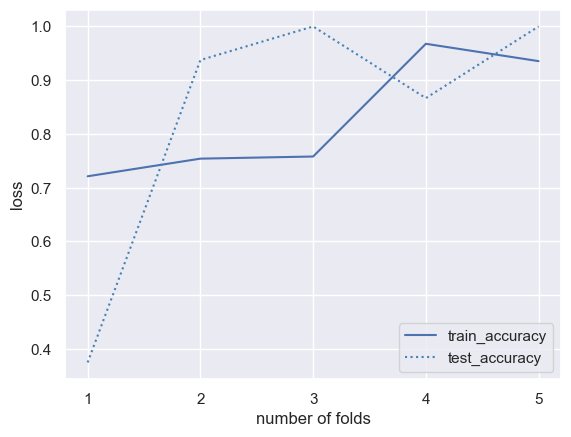

In [24]:
class Classifier(nn.Module): #a very simple classifer with large dropout. intuition here: as simple as possible, given that we only have 2d input
    def __init__(self):
        super(Classifier, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(4,8),
            nn.Dropout(0.5),
            nn.Linear(8,1),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        return self.fc(x)

#%%Classifier training, Again you can play around with params just to see how it affects the model accuracy (training and tesing)

class AttributeDataset(Dataset): # this is for classifier 
    '''
    Args: x is a 2D numpy array [x_size, x_features]
    '''
    def __init__(self, x, y):
        self.x = x
        self.y = y
    def __len__(self):
        return self.x.shape[0]
    def __getitem__(self, idx):
        return torch.Tensor(self.x[idx]), torch.Tensor(self.y[idx])

from matplotlib.pyplot import MultipleLocator
same_seeds(1)

params['cls_bs'] = 16
params['cls_lr'] = 1e-4
params['cls_epoch'] = 100
params['num_fold'] = 5


params['label_y'] = np.where(raw_y>65, 1, 0)



params['latents'] = np.concatenate((latents_A,latents_B),axis=1)

cls = Classifier().to(device)
opt = Adam(cls.parameters(), lr=params['cls_lr'], weight_decay=0.)


def training_Cls(model, optimizer, params):
    label_y = params['label_y']
    latents = params['latents']
    cls_epoch = params['cls_epoch']

    kf = KFold(n_splits=params['num_fold'])
    train_acc = []
    test_acc = []

    k=1
    for train, test in kf.split(latents):
        x_train, x_test, y_train, y_test = latents[train], latents[test], label_y[train], label_y[test]
        cls_dataset = AttributeDataset(x_train, y_train)
        cls_dataloader = DataLoader(cls_dataset, batch_size=params['cls_bs'], shuffle=True)
        cls_testDataset = AttributeDataset(x_test, y_test)
        cls_testDataloader = DataLoader(cls_testDataset, batch_size=cls_testDataset.__len__(), shuffle=False)


        for epoch in range(cls_epoch):
            t = time.time()
            total_loss = []
            total_acc = []
            cls.train()
            
            for i, data in enumerate(cls_dataloader):
                x = data[0].to(device)
                y = data[1].to(device)
                y_pred = cls(x)
                loss = F.binary_cross_entropy(y_pred, y)
                total_acc.append(torch.sum(torch.where(y_pred>=0.5,1,0) == y).detach().cpu().numpy())
                total_loss.append(loss.item())

                opt.zero_grad()
                loss.backward()
                opt.step()
            
            #eval
            cls.eval()
            for test in cls_testDataloader:
                x = test[0].to(device)
                y = test[1].to(device)
                y_pred = cls(x)
                accuracy = torch.sum(torch.where(y_pred>=0.5,1,0) == y) / y_pred.size(0)
                test_loss = F.binary_cross_entropy(y_pred, y)

            #print(f'[{epoch+1:03}/{cls_epoch}] loss:{sum(total_loss)/len(total_loss):.3f} test_loss:{test_loss.item():.3f} acc:{sum(total_acc)/cls_dataset.__len__():.3f} test_acc:{accuracy:.3f} time:{time.time()-t:.3f}')
        
        print('[{}/{}] train_acc: {:.04f} || test_acc: {:.04f}'.format(k, params['num_fold'], sum(total_acc)/cls_dataset.__len__(), accuracy.item()))
        train_acc.append(sum(total_acc)/cls_dataset.__len__())
        test_acc.append(accuracy.item())
        k+=1
    print('train_acc: {:.04f} || test_acc: {:.04f}'.format(sum(train_acc)/len(train_acc), sum(test_acc)/len(test_acc)))
    plt.figure()
    sns.set_style()
    plt.xlabel('number of folds')
    plt.ylabel('loss')
    x=range(1,params['num_fold']+1)
    sns.set_style("darkgrid")
    x_major_locator=MultipleLocator(1)
    ax=plt.gca()
    plt.plot(x, train_acc)
    plt.plot(x, test_acc, linestyle=':', c='steelblue')
    plt.legend(["train_accuracy", "test_accuracy"])
    ax.xaxis.set_major_locator(x_major_locator)
    #plt.savefig('.figure/binary_classifier.png',dpi=300)
    return train_acc, test_acc

train_acc, test_acc = training_Cls(cls, opt, params)

## Gaussian mixture density image and elbow map

D:\anaconda\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
D:\anaconda\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\Administrator\AppData\Local\Temp\ipykernel_28704\1198728244.py:25: MatplotlibDeprecationWarning: Passing the angle parameter of __init__() positionally is deprecated since Matplotlib 3.6; the parameter will become keyword-only two minor releases later.
  ax.add_patch(Ellipse(position, nsig * width, nsig * height, angle, **kwargs))
D:\anaconda\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory

Average negative log likelihood: 2.749915160529247
Average negative log likelihood: 4.618233235641736
Average negative log likelihood: 4.216173294390486


D:\anaconda\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
D:\anaconda\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
D:\anaconda\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
D:\anaconda\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than availabl

Average negative log likelihood: 4.0131391620100025
Average negative log likelihood: 3.7000894478690536
Average negative log likelihood: 2.749915160529247
Average negative log likelihood: 2.5610911623956345
Average negative log likelihood: 2.4567874094552136


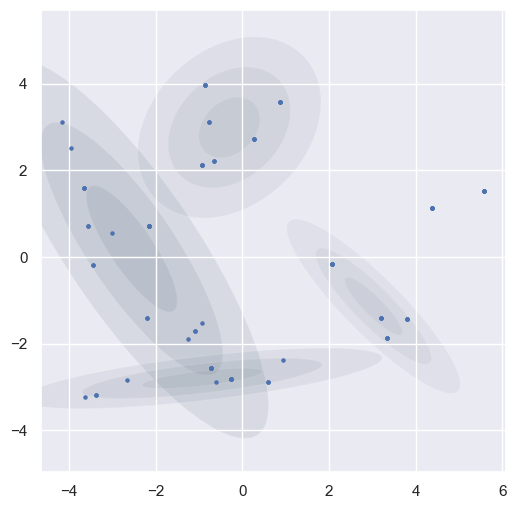

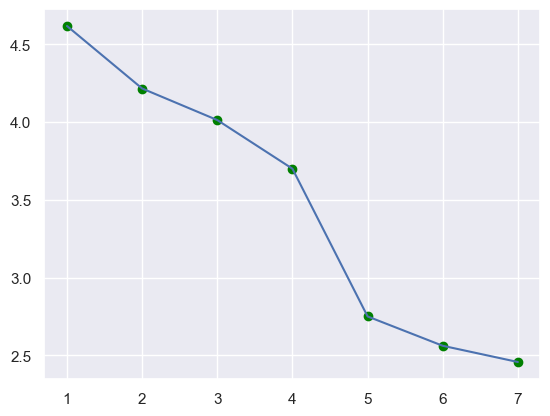

In [26]:
def plot_gmm(gm, X, ax=None):
    fig, ax = plt.subplots(figsize=(6, 6)) if ax is None else (None, ax)
    labels = gm.fit(X).predict(X)
    ax.scatter(X[:, 0], X[:, 1], s=5, zorder=2)
    ax.axis('equal')
    
    w_factor = 0.2 / gm.weights_.max()
    for pos, covar, w in zip(gm.means_, gm.covariances_, gm.weights_):
        draw_ellipse(ax, pos, covar, alpha=0.75*w*w_factor, facecolor='slategrey', zorder=-10)

def draw_ellipse(ax, position, covariance, **kwargs):
    """Draw an ellipse with a given position and covariance"""
    
    # Convert covariance to principal axes
    if covariance.shape == (2, 2):
        U, s, Vt = np.linalg.svd(covariance)
        angle = np.degrees(np.arctan2(U[1, 0], U[0, 0]))
        width, height = 2 * np.sqrt(s)
    else:
        angle = 0
        width, height = 2 * np.sqrt(covariance)
    
    # Draw the Ellipse
    for nsig in range(1, 4):
        ax.add_patch(Ellipse(position, nsig * width, nsig * height, angle, **kwargs))
        

latents=np.concatenate((latents_A,latents_B),axis=1)
pca = PCA(n_components=2)
pca.fit(latents)
x = pca.transform(latents)
gm = GaussianMixture(n_components=5, random_state=0, init_params='kmeans').fit(x) #plot a n_components v.s. Average negative log likelihood
print('Average negative log likelihood:', -1*gm.score(x))
plot_gmm(gm, x)

# Using elbow method to find out the best # of components, the lower the negative log likehood the better the model is, but too many cluster is trivial. just imagine you fit each individual data points with a Gaussian, in this case, you would have a very good model. but the such fitting is not very useful.

# In this case, the best number of cluster is either 4 or 5.

scores=[] #using elbow method to find out the best # of components
for i in range(1,8):
  gm = GaussianMixture(n_components=i, random_state=0, init_params='kmeans').fit(x)
  print('Average negative log likelihood:', -1*gm.score(x))
  scores.append(-1*gm.score(x))
  
sns.set_style("darkgrid")
plt.figure()
plt.scatter(range(1,8), scores,color='green')
plt.plot(range(1,8),scores)
plt.savefig('elbow_plot.png', format='png', dpi=300)
plt.show()

In [ ]:
gm = GaussianMixture(n_components=5).fit(latents)
# same_seeds(14368)
def MCMC(gm, classifier, n_samples, sigma=0.5): #MCMC
    sample_z = []

    z = gm.sample(1)[0]
    for i in range(n_samples):
        uniform_rand = np.random.uniform(size=1)
        z_next = np.random.multivariate_normal(z.squeeze(),sigma*np.eye(4)).reshape(1,-1)

        z_combined = np.concatenate((z, z_next),axis=0)
        scores = cls(torch.Tensor(z_combined).to(device)).detach().cpu().numpy().squeeze() 
        z_score, z_next_score = np.log(scores[0]), np.log(scores[1]) #z score needes to be converted to log, coz gm score is log.
        z_prob, z_next_prob = (gm.score(z)+z_score), (gm.score(z_next)+z_next_score) # two log addition, output: log probability
        accepence = min(0, (z_next_prob - z_prob))

        if i == 0:
            sample_z.append(z.squeeze())

        if np.log(uniform_rand) < accepence:
            sample_z.append(z_next.squeeze())
            z = z_next
        else:
            pass

    return np.stack(sample_z)

#%%Sample 5000 times with sigma=0.5
sample_z = MCMC(gm=gm, classifier=cls, n_samples=5000, sigma=0.5)
WAE_comps_A = model_A._decode(torch.Tensor(sample_z[:,0:2]).to(device)).detach().cpu().numpy()
WAE_comps_B = model_B._decode(torch.Tensor(sample_z[:,2:4]).to(device)).detach().cpu().numpy()
WAE_comps = np.concatenate((WAE_comps_A,WAE_comps_B),axis = 1)# new_comps save as csv and goes to TERM   
WAE_comps=pd.DataFrame(WAE_comps)
WAE_comps.columns=column_names
WAE_comps.to_csv('generate.csv',index=False)
WAE_comps.shape

## descprition construction

In [28]:
import numpy as np
import pandas as pd
from pymatgen.core import Element

# Load data
#data = pd.read_csv('origin_data.csv')
data = pd.read_csv('generate_data.csv')

# Define elements
elements = data.columns[2:11]
A_elements = data.columns[2:6]
B_elements = data.columns[6:11]

# Define properties
properties = ['Molar volume', 'Ionization energy', 'Electron affinity', 'Row', 
              'Atomic mass', 'Number', 'Ionic radii', 'Bond length', 'Atomic radius', 
              'Van der Waals radius', 'X']

# Initialize property dictionaries
property_values = {property_name: [] for property_name in properties}

# Populate property values
for element_name in elements:
    element = Element(element_name)
    property_values['Molar volume'].append(float(re.findall(r'\d+\.\d+', element.data['Molar volume'])[0]))
    property_values['Ionization energy'].append(element.ionization_energy)
    property_values['Electron affinity'].append(element.electron_affinity)
    property_values['Row'].append(element.row)
    property_values['Atomic mass'].append(element.atomic_mass)
    property_values['Number'].append(element.number)
    property_values['Ionic radii'].append(element.ionic_radii)
    property_values['Atomic radius'].append(element.atomic_radius)
    property_values['Van der Waals radius'].append(element.data['Van der waals radius'])
    property_values['X'].append(element.X)

# Manually define properties with constant values
property_values['Ionic radii'] = [1.17, 1.1172, 1.32, 1.14, 1.0, 0.86, 0.97, 0.86, 0.85]
property_values['Bond length'] = [2.06, 2.172, 2.68, 1.967, 2.32, 1.693, 1.790, 2.48, 2.47]

# Calculate descriptors for A and B sites
for site, elements_subset in zip(['A', 'B'], [list(A_elements), list(B_elements)]):
    for property_name, values in property_values.items():
        site_property_values = np.array([values[elements.get_loc(elem)] for elem in elements_subset])
        data[f'{site}_site_{property_name.replace(" ", "_")}'] = np.sum(
            site_property_values * data[elements_subset].values.astype(float), axis=1
        ) / len(elements_subset)


# Calculate entropy formation ability
data['Entropy'] = (
    np.sum(-data[B_elements].values * np.log(np.maximum(data[B_elements].values, 1e-12)), axis=1) +
    np.sum(-data[A_elements].values * np.log(np.maximum(data[A_elements].values, 1e-12)), axis=1)
)


# Calculate tolerance factor
data['Tolerance_factor'] = (data['A_site_Ionic_radii'] + 1.26) / (
    np.sqrt(2) * (data['B_site_Ionic_radii'] + 1.26)
)

# Calculate octahedral factor
data['Octahedral_factor'] = data['B_site_Ionic_radii'] / 1.26

# Save the processed data
#data.to_csv('processed_data_with_descriptors.csv', index=False)
data.to_csv('processed_generated_data_with_descriptors.csv', index=False)


## Data load

In [29]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
import datetime

class MAPELoss(nn.Module):
    """Mean Absolute Percentage Error Loss"""

    def __init__(self):
        super(MAPELoss, self).__init__()

    def forward(self, output, target):
        """
        Compute the mean absolute percentage error loss.

        Args:
            output (torch.Tensor): Predicted values.
            target (torch.Tensor): Ground truth values.

        Returns:
            torch.Tensor: Mean absolute percentage error loss.
        """
        loss = torch.mean(torch.abs((target - output) / target))
        return loss

def minmaxscaler(data):
    """Min-Max Scaling of the data"""
    min_val = np.amin(data)
    max_val = np.amax(data)
    scaled_data = (data - min_val) / (max_val - min_val)
    return scaled_data

def normalizing_data(data, seed=42):
    """
    Normalize the data and split it into training and testing sets.

    Args:
        data (pd.DataFrame): Input data.
        seed (int): Random seed for train-test split. Default is 42.

    Returns:
        tuple: Tuple containing the normalized features and labels for training and testing.
    """
    df_all = data.iloc[:, :]
    composition = df_all[['Bi', 'La', 'Sr', 'Ca', 'Ti', 'Mg', 'Mn', 'Zr', 'Hf']]
    min_max_scaler = preprocessing.MinMaxScaler()
    normalized_atomic_properties_TD = min_max_scaler.fit_transform(df_all.iloc[:, 9:11])
    normalized_atomic_properties_F = min_max_scaler.fit_transform(df_all.iloc[:, 13:])
    x = pd.concat([composition, pd.DataFrame(normalized_atomic_properties_TD),
                   pd.DataFrame(normalized_atomic_properties_F)], axis=1)
    y = df_all[['Eenergy_density']][:]

    x_all = torch.FloatTensor(x.values)
    y_all = torch.FloatTensor(y.values)

    if torch.cuda.is_available():
        x_all = x_all.cuda()
        y_all = y_all.cuda()

    train_features, test_features, train_labels, test_labels = train_test_split(x_all, y_all, test_size=0.15,
                                                                                random_state=seed)
    return x_all, y_all,train_features, test_features, train_labels, test_labels






In [30]:
# Initialize DataFrame for logging
table = pd.DataFrame(columns=['target', 'batch_size', 'lr', 'module__n_hidden', 'module__w'])

# Set seed and preprocess data
starttime = datetime.datetime.now()
data = pd.read_csv('processed_data_with_descriptors.csv').iloc[:, 2:]
x_all, y_all, train_features, test_features, train_labels, test_labels = normalizing_data(data, seed=42)

## Prediction

In [31]:
class Net(nn.Module):  
    def __init__(self, n_feature=36, n_hidden=218, n_output=1, w=6):
        super(Net, self).__init__()    
        self.hidden1 = torch.nn.Linear(n_feature, n_hidden) 
        nn.init.kaiming_normal_(self.hidden1.weight)
        
        self.hiddens = nn.ModuleList([nn.Linear(n_hidden, n_hidden) for _ in range(w)])
        for m in self.hiddens:
            nn.init.kaiming_normal_(m.weight)   
        
        self.predict = torch.nn.Linear(n_hidden, n_output)  
        nn.init.kaiming_normal_(self.predict.weight)

    def forward(self, x):  
        x = self.hidden1(x)
        x = F.relu(x)   
        
        for m in self.hiddens:
            x = m(x)
            x = F.relu(x) 
                      
        x = self.predict(x)
        return x

def train(net, num_epochs, batch_size, train_features, test_features, train_labels, test_labels, train_loader, optimizer):
    print("=== Training begins ===")
    train_ls, test_ls = [], []
    loss = MAPELoss() 
    for epoch in range(num_epochs):
        for x, y in train_loader:
            ls = loss(net(x).view(-1, 1), y.view(-1, 1))
            optimizer.zero_grad()
            ls.backward()
            optimizer.step()
        if epoch % 100 == 0:
            train_ls.append(loss(net(train_features).view(-1, 1), train_labels.view(-1, 1)).item())
            test_ls.append(loss(net(test_features).view(-1, 1), test_labels.view(-1, 1)).item())
            print(f"Epoch {epoch}: Train loss {train_ls[-1]}, Test loss {test_ls[-1]}")
    print("=== Training ends ===")

def test(model, test_loader): 
    model.eval()
    test_loss = 0
    n = 0
    loss = MAPELoss() 
    with torch.no_grad():
        for data, target in test_loader:
            output = model(data)
            test_loss += loss(output.view(-1, 1), target.view(-1, 1)).item()
            n += 1
    test_loss /= n
    print(f'Test set: Average loss: {test_loss:.4f}')
    return test_loss 

def plotCurve(x_vals, y_vals, 
              x_label, y_label, 
              x2_vals=None, y2_vals=None, 
              legend=None,
              figsize=(3.5, 2.5)):
    plt.figure(figsize=figsize)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.plot(x_vals, y_vals)
    if x2_vals and y2_vals:
        plt.plot(x2_vals, y2_vals, linestyle=':')      
    if legend:
        plt.legend(legend)
    plt.show()
    
def train_model(batch_size, lr, module__n_hidden, module__w):
    """Train the neural network model with given hyperparameters"""
    module__n_hidden = int(module__n_hidden) 
    module__w = int(module__w) 
    batch_size = int(batch_size)
    train_dataset = Data.TensorDataset(train_features, train_labels)
    test_dataset = Data.TensorDataset(test_features, test_labels)
    train_loader = Data.DataLoader(train_dataset, batch_size, shuffle=True)
    test_loader = Data.DataLoader(test_dataset, batch_size, shuffle=True) 
    net = Net(n_feature=36, n_hidden=module__n_hidden, n_output=1, w=module__w)
    if torch.cuda.is_available():
      net = net.cuda()
    n_epochs = 1000 
    optimizer = optim.Adam(net.parameters(), lr=lr, weight_decay=0.0001)
    train(net, n_epochs, batch_size, train_features, test_features, 
          train_labels, test_labels, train_loader, optimizer)
    train_loss = test(net, train_loader)
    test_loss = test(net, test_loader)
    r = -np.abs(train_loss - test_loss)
    return -test_loss  

### Use BO to find the best parameters for NN



In [ ]:
bounds = {'lr': (0.0005,0.001), 'batch_size': (32,64), 'module__n_hidden': (16,526),
          'module__w': (2,10)} #this is the bounds where you are trying to find the best parameter combination
optimizer = BayesianOptimization(
    f=train_model,
    pbounds=bounds,
    random_state=1,
)

optimizer.maximize()#init_points is where you start and do n_iterations (n_iter) BO
print(optimizer.max)
table = pd.DataFrame(columns=['target','batch_size','lr','module__n_hidden','module__w']) #save the results into a dataframe
for res in optimizer.res:
    table=pd.concat([table,pd.DataFrame({'target':[res['target']],'batch_size':[res['params']['batch_size']],
                                     'lr':[res['params']['lr']], 'module__n_hidden':[res['params']['module__n_hidden']],
                                     'module__w':[res['params']['module__w']]})])

table=table.sort_values(by = ['target'],ascending=False)#sort the list start from the best results
model_name = 'HEC_BO_NN'
file_name = '{}.xlsx'.format(model_name)
#endtime = datetime.datetime.now()
#Rtime = endtime - starttime #if it takes long time you can record it.
#print(Rtime)
table.to_excel(file_name)#save the results to the table
print(table)

### **Use BO to optimize the parameters of LightGBM**

In [ ]:

# Define model and file names
model_name = 'HEC_BO_GBDT'
file_name = '{}.xlsx'.format(model_name)

# Normalize data and split into train-test sets
x_all, y_all, train_features, test_features, train_labels, test_labels = normalizing_data(data, seed=42)
train_features, test_features = train_features.cpu().data.numpy(), test_features.cpu().data.numpy()
train_labels, test_labels = train_labels.cpu().data.numpy(), test_labels.cpu().data.numpy()
train_labels, test_labels = train_labels.reshape(-1), test_labels.reshape(-1) 

# Define the function for training the model
def train_model(num_leaves, min_child_samples, learning_rate, n_estimators, max_bin,
                colsample_bytree, subsample, max_depth, reg_alpha, reg_lambda,
                min_split_gain, min_child_weight):
    params = {
        "num_leaves": int(round(num_leaves)),
        'min_child_samples': int(round(min_child_samples)),
        'learning_rate': learning_rate,
        'n_estimators': int(round(n_estimators)),
        'max_bin': int(round(max_bin)),
        'colsample_bytree': max(min(colsample_bytree, 1), 0),
        'subsample': max(min(subsample, 1), 0),
        'max_depth': int(round(max_depth)),
        'reg_alpha':  max(reg_alpha, 0),
        'reg_lambda': max(reg_lambda, 0),
        'min_split_gain': min_split_gain,
        'min_child_weight': min_child_weight,
        'verbose': -1
    } 
    model = LGBMRegressor(metric='mape', **params)
    model.fit(train_features, train_labels)
    y_pred = model.predict(test_features)
    error = -np.mean(np.abs((test_labels - y_pred) / test_labels))
    return error

# Define the bounds for Bayesian Optimization
bounds = {'num_leaves': (5, 60),
          'min_child_samples': (1, 50),
          'learning_rate': (0.1, 5),
          'n_estimators': (100, 1000),
          'max_bin': (5, 20),
          'colsample_bytree': (0.5, 1),
          'subsample': (0.1, 2),
          'max_depth': (5, 60),
          'reg_alpha': (0.05, 5),
          'reg_lambda': (0.05, 5),
          'min_split_gain': (0.001, 0.1),
          'min_child_weight': (0.001, 30)}

# Initialize Bayesian Optimization
optimizer = BayesianOptimization(
    f=train_model,
    pbounds=bounds,
    random_state=1,
)
optimizer.maximize(n_iter=500)

# Create a DataFrame to store the optimization results
table = pd.DataFrame(columns=['target', 'colsample_bytree', 'learning_rate', 'max_bin',
                               'max_depth', 'min_child_samples', 'min_child_weight', 'min_split_gain',
                               'n_estimators', 'num_leaves', 'reg_alpha', 'reg_lambda', 'subsample'])

# Store the results in the DataFrame
for res in optimizer.res:
    table = table.append(pd.DataFrame({'target': [res['target']], 'colsample_bytree': [res['params']['colsample_bytree']],
                                       'colsample_bytree': [res['params']['colsample_bytree']],
                                       'learning_rate': [res['params']['learning_rate']],
                                       'max_bin': [res['params']['max_bin']],
                                       'max_depth': [res['params']['max_depth']],
                                       'min_child_samples': [res['params']['min_child_samples']],
                                       'min_child_weight': [res['params']['min_child_weight']],
                                       'min_split_gain': [res['params']['min_split_gain']],
                                       'n_estimators': [res['params']['n_estimators']],
                                       'num_leaves': [res['params']['num_leaves']],
                                       'reg_alpha': [res['params']['reg_alpha']],
                                       'reg_lambda': [res['params']['reg_lambda']],
                                       'subsample': [res['params']['subsample']]}),
                         ignore_index=True)

# Sort the DataFrame by target value in descending order
table = table.sort_values(by=['target'], ascending=False)

# Save the results to an Excel file
table.to_excel(file_name)


### **Assess the performance/accuracy of NN and LightGBM**

In [ ]:
import seaborn as sns
import os
import torch
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
import pandas as pd

# Load the best parameters obtained from Bayesian Optimization for NN
target = pd.read_excel('HEC_BO_NN.xlsx')
lr = float(target.at[1, 'lr'])
module__n_hidden = int(target.at[1, 'module__n_hidden'])
module__w = int(target.at[1, 'module__w'])
batch_size = int(target.at[1, 'batch_size'])

# Normalize and split the data
x_all, y_all, train_features, test_features, train_labels, test_labels = normalizing_data(data)
train_dataset = TensorDataset(train_features, train_labels)
test_dataset = TensorDataset(test_features, test_labels)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

# Train the Neural Network
print("\n=== Training begins ===")
net = Net(n_feature=36, n_hidden=module__n_hidden, n_output=1, w=module__w)
print(net)
if torch.cuda.is_available():
    net = net.cuda()
loss_func = MAPELoss()
optimizer = optim.Adam(net.parameters(), lr=lr, weight_decay=0.0001)
train_losses, test_losses = [], []
n_epochs = 3000
for epoch in range(n_epochs):
    for x, y in train_loader:
        optimizer.zero_grad()
        output = net(x)
        loss = loss_func(output.view(-1, 1), y.view(-1, 1))
        loss.backward()
        optimizer.step()
    train_loss = loss_func(net(train_features).view(-1, 1), train_labels.view(-1, 1)).item()
    test_loss = loss_func(net(test_features).view(-1, 1), test_labels.view(-1, 1)).item()
    train_losses.append(train_loss)
    test_losses.append(test_loss)
    if epoch % 100 == 0:
        print(f"Epoch {epoch}: Train Loss {train_loss}, Test Loss {test_loss}")

# Plot training curves
plt.plot(range(1, n_epochs + 1), train_losses)
folder_dir = 'Figures'
if not os.path.isdir(folder_dir):
    os.mkdir(folder_dir)
plt.savefig('Figures/NN_training_history.png', format='png', dpi=300)

# Save the trained model
folder_dir = 'Model'
if not os.path.isdir(folder_dir):
    os.mkdir(folder_dir)
torch.save(net.state_dict(), 'Model/HEC_NN.pt')

In [ ]:
import lightgbm as lgb
#load the parameters of BO
target = pd.read_excel('HEC_BO_GBDT.xlsx')
colsample_bytree = target.at[1,'colsample_bytree']
learning_rate = target.at[1,'learning_rate']
max_bin = target.at[1,'max_bin']
max_depth = target.at[1,'max_depth']
max_bin = target.at[1,'max_bin']
min_child_samples = target.at[1,'min_child_samples']
min_child_weight = target.at[1,'min_child_weight']
min_split_gain= target.at[1,'min_split_gain']
n_estimators = target.at[1,'n_estimators']
num_leaves = target.at[1,'num_leaves']
reg_alpha = target.at[1,'reg_alpha']
reg_lambda = target.at[1,'reg_lambda']
subsample = target.at[1,'subsample']
params = {
    "num_leaves": int(round(num_leaves)),
   'min_child_samples':int(round(min_child_samples)),
    'learning_rate': learning_rate,
    'n_estimators': int(round(n_estimators)),

    'max_bin': int(round(max_bin)),
    'colsample_bytree': max(min(colsample_bytree, 1), 0),
    'subsample': max(min(subsample, 1), 0),
    'max_depth': int(round(max_depth)),
    'reg_lambda':  max(reg_lambda, 0),
    'reg_alpha': max(reg_alpha, 0),
    'min_split_gain': min_split_gain,
    'min_child_weight': min_child_weight,
    'objective': 'regression',
    'verbose': -1
              }
      
x_all, y_all, train_features, test_features, train_labels, test_labels = normalizing_data(data)
train_features, test_features = train_features.cpu().data.numpy(),test_features.cpu().data.numpy()
train_labels, test_labels = train_labels.cpu().data.numpy(), test_labels.cpu().data.numpy()
train_labels, test_labels = train_labels.reshape(-1), test_labels.reshape(-1)   
model = LGBMRegressor(metric='mape',**params)
model.fit(train_features, train_labels, eval_set=[(test_features, test_labels), (train_features, train_labels)], 
          eval_metric='error', verbose=10)
#plot the traiining history
lgb.plot_metric(model)
plt.ylabel('loss')
plt.xlabel ('epoch')
folder_dir = 'Figures'
if not os.path.isdir(folder_dir):
  os.mkdir(folder_dir)
plt.savefig('Figures/GBDT_trainning history.png', format='png', dpi=300)
#save the models
folder_dir = 'Model'
if not os.path.isdir(folder_dir):
  os.mkdir(folder_dir)
net_name = 'Model/HEC_GBDT.pt'
torch.save(net.state_dict(), net_name)

## Machine learning pipline

### Import data. 

In [63]:
#Training data (85%) are labelled, and testing data (15%) are unlabelled. We will use the Training data to predict the alloys in the testing data
def normalizing_data(data, seed=42): #norminliz the data 
  df_all = data.iloc[:,:]
  #create a min max processing object
  composition = df_all [['Bi','La','Sr','Ca','Ti','Mg','Mn','Zr','Hf']]
  min_max_scaler = preprocessing.MinMaxScaler()
  normalized_atomic_properties_TD = min_max_scaler.fit_transform(df_all.iloc[:,9:11])
  normalized_atomic_properties_F = min_max_scaler.fit_transform(df_all.iloc[:,13:])
  x = pd.concat([composition,pd.DataFrame(normalized_atomic_properties_TD),pd.DataFrame(normalized_atomic_properties_F)],axis=1)
  y = df_all[['energy_density']][:]
  
  x_all = torch.FloatTensor(x.values) #numpy to tensor
  y_all = torch.FloatTensor(y.values) #numpy to tensor

  if torch.cuda.is_available():
      x_all = x_all.cuda()
      y_all = y_all.cuda() 
  
  train_features, test_features, train_labels, test_labels = train_test_split(x_all, y_all, test_size=0.15, random_state=seed, stratify=y_binned)
  return x_all, y_all, train_features, test_features, train_labels, test_labels

### 集成模型 NN+GBDT

In [64]:
import datetime
import torch.utils.data as Data
import pandas as pd
import torch
import torch.nn.functional as F   
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
import torch.nn as nn
import torch.optim as optim
import time
import os
import pickle 
import seaborn as sns
def ensemble_model(train_features, test_features, train_labels, test_labels, i):
    #NN 
    target_NN = pd.read_excel('HEC_BO_NN.xlsx')#get the best BO parameter for NN
    lr = target_NN.at[i,'lr'] # i means the ith parameter in the BO results
    module__n_hidden = target_NN.at[i,'module__n_hidden']
    module__w = target_NN.at[i,'module__w']
    batch_size = target_NN.at[i,'batch_size']

    module__n_hidden = int(module__n_hidden)
    module__w = int(module__w)
    batch_size = int(batch_size)

    #print('batch_size is {}'.format(batch_size))

    train_dataset = Data.TensorDataset(train_features, train_labels)
    #test_dataset = Data.TensorDataset(test_features, test_labels)
    train_loader = Data.DataLoader(train_dataset, batch_size, shuffle=True)
    #test_loader = Data.DataLoader(test_dataset, batch_size, shuffle=True)
    
    module__n_hidden = int(module__n_hidden)
    module__w = int(module__w)
    batch_size = int(batch_size)
    
    #training NN 
    net = Net()
    if torch.cuda.is_available():
        net = net.cuda()    
    train_ls, test_ls = [], []
    loss = MAPELoss() 
    n_epochs = 1000
    optimizer = optim.Adam(net.parameters(), lr=lr, weight_decay=0.0001)
    #print('n_epochs is {}'.format(n_epochs))
    for epoch in range(n_epochs):
        for x, y in train_loader:
            ls = loss(net(x).view(-1, 1), y.view(-1, 1))
            optimizer.zero_grad()
            ls.backward()
            optimizer.step()
        train_ls.append(loss(net(train_features).view(-1, 1), train_labels.view(-1, 1)).item())
        #if epoch % 100 == 0:
            #print ("epoch %d: train loss %f" % (epoch, train_ls[-1]))                  
    #predicting
    net.eval()
    NN_predict=net(test_features).cpu().data.numpy()

    target_GBDT = pd.read_excel('HEC_BO_GBDT.xlsx')#get the best BO parameter for GBDT
    colsample_bytree = target_GBDT.at[i,'colsample_bytree']
    learning_rate = target_GBDT.at[i,'learning_rate']
    max_bin = target_GBDT.at[i,'max_bin']
    max_depth = target_GBDT.at[i,'max_depth']
    max_bin = target_GBDT.at[i,'max_bin']
    min_child_samples = target_GBDT.at[i,'min_child_samples']
    min_child_weight = target_GBDT.at[i,'min_child_weight']
    min_split_gain= target_GBDT.at[i,'min_split_gain']
    n_estimators = target_GBDT.at[i,'n_estimators']
    num_leaves = target_GBDT.at[i,'num_leaves']
    reg_alpha = target_GBDT.at[i,'reg_alpha']
    reg_lambda = target_GBDT.at[i,'reg_lambda']
    subsample = target_GBDT.at[i,'subsample']
    params = {
        "num_leaves": int(round(num_leaves)),
        'min_child_samples':int(round(min_child_samples)),
        'learning_rate': learning_rate,
        'n_estimators': int(round(n_estimators)),
        'max_bin': int(round(max_bin)),
        'colsample_bytree': max(min(colsample_bytree, 1), 0),
        'subsample': max(min(subsample, 1), 0),
        'max_depth': int(round(max_depth)),
        'reg_lambda':  max(reg_lambda, 0),
        'reg_alpha': max(reg_alpha, 0),
        'min_split_gain': min_split_gain,
        'min_child_weight': min_child_weight,
        'objective': 'regression',
        'verbose': -1
                  }
    model = LGBMRegressor(metric='mape',**params)
    #print('GBDT training start_______')
    model.fit(train_features.cpu().data.numpy(), train_labels.cpu().data.numpy())
    #print('GBDT training end_______')
    GBDT_predict = model.predict(test_features.cpu().data.numpy())

    return (NN_predict,GBDT_predict)

### 集成训练

In [65]:
from pandas.core.common import index_labels_to_array
from tqdm import tqdm
def ensemble_training(train_features, test_features, train_labels, test_labels, number):
  single_predict = pd.DataFrame()
  Comp_total = pd.DataFrame(test_features.cpu().data.numpy(), columns=data.columns)
  #print(number)
  for j in tqdm(range(number)):
    #print ('prediction_round_{}'.format(j))
    NN_predict, GBDT_predict = ensemble_model(train_features, test_features, train_labels, test_labels, j)
    single_predict['pred_Tree_{}'.format(j)] = GBDT_predict
    single_predict['pred_NN_{}'.format(j)] = NN_predict 
  prediciton_mean = single_predict.mean(axis=1)
  prediciton_std = single_predict.std(axis=1)
  Comp_total['prediction_mean'] = prediciton_mean
  Comp_total['prediction_std'] = prediciton_std 
  Comp_total['true_value'] = test_labels.cpu().data.numpy()
  return Comp_total, single_predict

### 已知数据的Rank-based exploration-exploitation strategy

In [66]:
def Ranking(Comp_total, alpha, beta): #alpha is exploitation and beta is exploration
  Comp_total=Comp_total.sort_values(by=['prediction_mean'],ascending=True)
  Comp_total['mean_rank'] = range(1,len(Comp_total)+1)
  Comp_total=Comp_total.sort_values(by=['prediction_std'],ascending=False)
  Comp_total['std_rank'] = range(1,len(Comp_total)+1)
  Comp_total['total_rank'] =Comp_total['mean_rank']*alpha+Comp_total['std_rank']*beta #total rank= mean_rank*alpha+std_rank*beta
  Comp_total=Comp_total.sort_values(by=['total_rank'],ascending=True)
  #Comp_total=Comp_total.drop(columns=['Unnamed: 0','Unnamed: 0.1','Unnamed: 0.1.1'])
  return Comp_total

### Machine learning explore α=0.9 β=0.1

In [71]:
data = pd.read_csv('processed_generated_data_with_descriptors.csv')#get the data
#x_all, y_all, train_features, test_features, train_labels, test_labels = normalizing_data(data,seed=42)
df_all = data.iloc[:,:]
#create a min max processing object
composition = df_all [['Bi','La','Sr','Ca','Ti','Mg','Mn','Zr','Hf']]
min_max_scaler = preprocessing.MinMaxScaler()
normalized_atomic_properties = min_max_scaler.fit_transform(df_all.iloc[:,9:])
x = pd.concat([composition,pd.DataFrame(normalized_atomic_properties)],axis=1)
x_all = torch.FloatTensor(x.values) #numpy to tensor
#y_all = torch.FloatTensor(y.values)


single_predict = pd.DataFrame()
Comp_total = pd.DataFrame(x_all.cpu().data.numpy(), columns=data.columns)
#print(n umber)
number = 10
for j in tqdm(range(number)):
#print ('prediction_round_{}'.format(j))
    target_NN = pd.read_excel('HEC_BO_NN.xlsx')#get the best BO parameter for NN
    lr = target_NN.at[j,'lr'] # i means the ith parameter in the BO results
    module__n_hidden = target_NN.at[j,'module__n_hidden']
    module__w = target_NN.at[j,'module__w']
    batch_size = target_NN.at[j,'batch_size']

    module__n_hidden = int(module__n_hidden)
    module__w = int(module__w)
    batch_size = int(batch_size)

    #print('batch_size is {}'.format(batch_size))

   # train_dataset = Data.TensorDataset(train_features, train_labels)
    #test_dataset = Data.TensorDataset(test_features, test_labels)
    train_loader = Data.DataLoader(train_dataset, batch_size, shuffle=True)
    #test_loader = Data.DataLoader(test_dataset, batch_size, shuffle=True)
    
    module__n_hidden = int(module__n_hidden)
    module__w = int(module__w)
    batch_size = int(batch_size)
    
    #training NN 
    net = Net()
    if torch.cuda.is_available():
        net = net.cuda()    
    train_ls, test_ls = [], []
    loss = MAPELoss() 
    n_epochs = 1000
    optimizer = optim.Adam(net.parameters(), lr=lr, weight_decay=0.0001)
    #print('n_epochs is {}'.format(n_epochs))
    for epoch in range(n_epochs):
        for x, y in train_loader:
            ls = loss(net(x).view(-1, 1), y.view(-1, 1))
            optimizer.zero_grad()
            ls.backward()
            optimizer.step()
       # train_ls.append(loss(net(torch.FloatTensor(train_features)), train_labels.view(-1, 1)).item())
        #if epoch % 100 == 0:
            #print ("epoch %d: train loss %f" % (epoch, train_ls[-1]))                  
    #predicting
    net.eval()
    NN_predict=net(x_all).cpu().data.numpy()

    #GBDT
    target_GBDT = pd.read_excel('HEC_BO_GBDT.xlsx')#get the best BO parameter for GBDT
    colsample_bytree = target_GBDT.at[j,'colsample_bytree']
    learning_rate = target_GBDT.at[j,'learning_rate']
    max_bin = target_GBDT.at[j,'max_bin']
    max_depth = target_GBDT.at[j,'max_depth']
    max_bin = target_GBDT.at[j,'max_bin']
    min_child_samples = target_GBDT.at[j,'min_child_samples']
    min_child_weight = target_GBDT.at[j,'min_child_weight']
    min_split_gain= target_GBDT.at[j,'min_split_gain']
    n_estimators = target_GBDT.at[j,'n_estimators']
    num_leaves = target_GBDT.at[j,'num_leaves']
    reg_alpha = target_GBDT.at[j,'reg_alpha']
    reg_lambda = target_GBDT.at[j,'reg_lambda']
    subsample = target_GBDT.at[j,'subsample']
    params = {
        "num_leaves": int(round(num_leaves)),
        'min_child_samples':int(round(min_child_samples)),
        'learning_rate': learning_rate,
        'n_estimators': int(round(n_estimators)),
        'max_bin': int(round(max_bin)),
        'colsample_bytree': max(min(colsample_bytree, 1), 0),
        'subsample': max(min(subsample, 1), 0),
        'max_depth': int(round(max_depth)),
        'reg_lambda':  max(reg_lambda, 0),
        'reg_alpha': max(reg_alpha, 0),
        'min_split_gain': min_split_gain,
        'min_child_weight': min_child_weight,
        'objective': 'regression',
        'verbose': -1
                  }
    model = LGBMRegressor(metric='mape',**params)
    #print('GBDT training start_______')
    model.fit(torch.FloatTensor(train_features).cpu().data.numpy(), torch.FloatTensor(train_labels).cpu().data.numpy())
    #print('GBDT training end_______')
    GBDT_predict = model.predict(x_all.cpu().data.numpy())

    single_predict['pred_Tree_{}'.format(j)] = GBDT_predict
    single_predict['pred_NN_{}'.format(j)] = NN_predict 
    
    prediciton_mean = single_predict.mean(axis=1)
    prediciton_std = single_predict.std(axis=1)
    Comp_total['prediction_mean'] = prediciton_mean
    Comp_total['prediction_std'] = prediciton_std 
   # Comp_total['true_value'] = torch.FloatTensor(test_labels).cpu().data.numpy()

alpha = 0.9
beta = 0.1
Comp_total=Comp_total.sort_values(by=['prediction_mean'],ascending=True)
Comp_total['mean_rank'] = range(1,len(Comp_total)+1)
Comp_total=Comp_total.sort_values(by=['prediction_std'],ascending=False)
Comp_total['std_rank'] = range(1,len(Comp_total)+1)
Comp_total['total_rank'] =Comp_total['mean_rank']*alpha+Comp_total['std_rank']*beta #total rank= mean_rank*alpha+std_rank*beta
Comp_total=Comp_total.sort_values(by=['total_rank'],ascending=True)#1 denotes the exploitaion, and 0 denotes exploration
#print(Comp_total)
Comp_total.to_excel(os.path.join(folder_dir,'Comp_total11.xlsx'),index=True, index_label='id')
single_predict.to_excel(os.path.join(folder_dir,'single_predict11.xlsx'))
#Experiments validation
Comp_total=pd.read_excel(os.path.join(folder_dir,'Comp_total11.xlsx'),index_col=0)
samples = 10
compositions = Comp_total.iloc[0:samples]
compositions = compositions[['Bi','La','Sr','Ca','Ti','Mg','Mn','Zr','Hf']]
compositions.to_excel(os.path.join(folder_dir,'compositions11.xlsx'),index=True,index_label='id')
print(compositions)

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [01:49<00:00, 10.94s/it]


            Bi        La        Sr            Ca        Ti        Mg  \
id                                                                     
730   0.999972  0.000010  0.000018  7.260000e-08  0.374147  0.369011   
728   0.998667  0.000552  0.000780  1.080000e-06  0.373795  0.368514   
729   0.999604  0.000165  0.000231  3.790000e-07  0.381463  0.381432   
895   0.926823  0.042829  0.030173  1.754510e-04  0.372732  0.368296   
2120  0.958568  0.005217  0.036191  2.400000e-05  0.374278  0.364452   
2125  0.997047  0.002140  0.000787  2.590000e-05  0.373992  0.366583   
2119  0.957194  0.011523  0.031253  2.920000e-05  0.380585  0.369447   
2123  0.960444  0.001577  0.037961  1.820000e-05  0.371364  0.361866   
899   0.941905  0.034609  0.023244  2.420340e-04  0.369544  0.362828   
2121  0.954542  0.002377  0.043059  2.170000e-05  0.377122  0.369068   

            Mn        Zr        Hf  
id                                  
730   0.067971  0.188832  0.000039  
728   0.066354  0.191297